# Exploring simple random sampling vs stratified sampling in classification

## Overview

The goal here is to try to assess whether stratified sampling is helpful in cases<br>
where class imbalance is not extreme. In these cases, a simple random sample will<br>
probably be enough to ensure that all classes appear in the training data. In a large<br>
enough dataset, the class proportions in the training data should also be close to<br>
the true proportions in the population.

*Approach*: simulate data for an imbalanced classification problem. Then compare<br>
simple random versus stratified sampling by fitting a logistic regression-based<br>
classifier in each case, and evaluating on a test set.

*Conclusion*: There does not seem to be a consistent benefit to stratified sampling<br>
in this case.

## Libraries

In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support

## Define parameters for creating a classification problem

In [2]:
@dataclass(frozen=True)
class MakeClassificationParams:
    """Class for holding parameters required by sklearn.datasets.make_classification"""
    num_samples: int
    num_classes: int
    weights: list
    num_features: int
    n_informative: int
    n_repeated: int
    n_redundant: int

## Set parameters

In [3]:
classification_params = MakeClassificationParams(
    num_samples=10000,
    num_classes=2,
    weights=[0.95, 0.05],
    num_features=3,
    n_informative=2,
    n_repeated=0,
    n_redundant=0,
)

In [4]:
test_size_second_split = 0.90
seed = 202206

## Simulate data

In [5]:
X, y = make_classification(
    n_samples=classification_params.num_samples,
    n_classes=classification_params.num_classes,
    weights=classification_params.weights,
    n_features=classification_params.num_features,
    n_informative=classification_params.n_informative,
    n_redundant=classification_params.n_redundant,
    n_repeated=classification_params.n_repeated,
    random_state=seed,
)

c:\Nayef\ml-notes\.venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


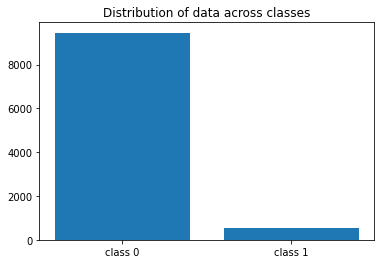

In [6]:
fig, ax = plt.subplots()
ax.bar(["class 0", "class 1"], pd.Series(y).value_counts().to_list())
ax.set_title("Distribution of data across classes")
fig.show()

Initial split into train/test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=seed
)

c:\Nayef\ml-notes\.venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


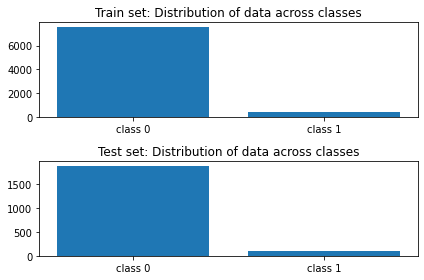

In [8]:
fig = plt.figure()
titles = [
    f"{dataset}: Distribution of data across classes"
    for dataset in ["Train set", "Test set"]
]
for i, target in enumerate([y_train, y_test]):
    ax = plt.subplot(2, 1, i + 1)
    ax.bar(["class 0", "class 1"], pd.Series(target).value_counts().to_list())
    ax.set_title(titles[i])
fig.tight_layout()
fig.show()

Second split into train/test datasets

In [9]:
X_train_simple_random_sample, _, y_train_simple_random_sample, _ = train_test_split(
    X_train, y_train, test_size=test_size_second_split, shuffle=True, random_state=seed
)

In [10]:
X_train_stratified_sample, _, y_train_stratified_sample, _ = train_test_split(
    X_train,
    y_train,
    test_size=test_size_second_split,
    stratify=y_train,
    shuffle=True,
    random_state=seed,
)

## Modeling with logistic regression

Model hyperparams

In [11]:
C = np.logspace(0, 4, 10)
penalty = ["l1", "l2"]
hyperparams = dict(C=C, penalty=penalty)

In [12]:
lr = LogisticRegression(solver="liblinear")

In [13]:
gridsearch = GridSearchCV(lr, hyperparams, cv=5, verbose=0)

## Analysis

Case 1:<br>
grid-search CV on train_simple_random_sample, and evaluate on *_test

plot

c:\Nayef\ml-notes\.venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


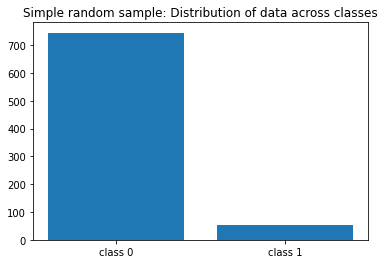

In [14]:
fig, ax = plt.subplots()
ax.bar(
    ["class 0", "class 1"],
    pd.Series(y_train_simple_random_sample).value_counts().to_list(),
)
ax.set_title("Simple random sample: Distribution of data across classes")
fig.show()

CV

In [15]:
best_model_01 = gridsearch.fit(
    X_train_simple_random_sample, y_train_simple_random_sample
)

In [16]:
best_penalty = best_model_01.best_estimator_.get_params()["penalty"]
best_C = best_model_01.best_estimator_.get_params()["C"]
print(f"Coefs from simple random sampling: {best_model_01.best_estimator_.coef_}")

Coefs from simple random sampling: [[-0.50184321  0.24890254  2.97452007]]


In [17]:
best_acc_score = best_model_01.best_estimator_.score(
    X_train_simple_random_sample, y_train_simple_random_sample
)
best_acc_score_test = best_model_01.best_estimator_.score(X_test, y_test)

In [18]:
y_pred_simple_random_train = best_model_01.best_estimator_.predict(
    X_train_simple_random_sample
)

In [19]:
best_results_train = precision_recall_fscore_support(
    y_train_simple_random_sample, y_pred_simple_random_train, average="binary"
)

In [20]:
y_pred_simple_random_sample_test = best_model_01.best_estimator_.predict(X_test)

In [21]:
best_results_test = precision_recall_fscore_support(
    y_test, y_pred_simple_random_sample_test, average="binary"
)

In [22]:
print("")
# print(f'Simple random sampling: Best accuracy score on train data: {best_acc_score}')
# print(f'Simple random sampling: Best accuracy score on test data: {best_acc_score_test}')  # noqa
# print(f'Simple random sampling: Best accuracy precision, recall, f1 on train: {best_results_train}')  # noqa
# print(f'Simple random sampling: Best accuracy precision, recall, f1 on test: {best_results_test}')  # noqa

Case 2:<br>
grid-search CV on train_simple_random_sample, and evaluate on _test

plot

c:\Nayef\ml-notes\.venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


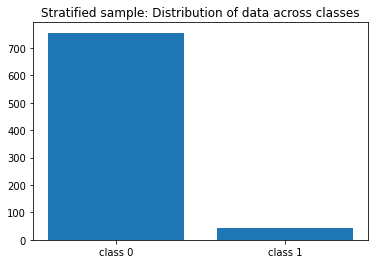

In [23]:
fig, ax = plt.subplots()
ax.bar(
    ["class 0", "class 1"],
    pd.Series(y_train_stratified_sample).value_counts().to_list(),
)
ax.set_title("Stratified sample: Distribution of data across classes")
fig.show()

CV

In [24]:
best_model_02 = gridsearch.fit(X_train_stratified_sample, y_train_stratified_sample)

In [25]:
best_penalty_02 = best_model_02.best_estimator_.get_params()["penalty"]
best_C_02 = best_model_02.best_estimator_.get_params()["C"]
print(f"Coefs from stratified sampling:    {best_model_02.best_estimator_.coef_}")

Coefs from stratified sampling:    [[-0.37038936  0.          2.66841923]]


In [26]:
best_acc_score_02 = best_model_02.best_estimator_.score(
    X_train_stratified_sample, y_train_stratified_sample
)
best_acc_score_test_02 = best_model_02.best_estimator_.score(X_test, y_test)

In [27]:
y_pred_stratified_train = best_model_02.best_estimator_.predict(
    X_train_stratified_sample
)

In [28]:
best_results_02_train = precision_recall_fscore_support(
    y_train_stratified_sample, y_pred_stratified_train, average="binary"
)

In [29]:
y_pred_stratified_test = best_model_02.best_estimator_.predict(X_test)

In [30]:
best_results_02_test = precision_recall_fscore_support(
    y_test, y_pred_stratified_test, average="binary"
)

# Summary

In [31]:
print("")

In [32]:
print(f"X.shape:       {X.shape}")
print(f"X_train.shape: {X_train.shape}")
print(f"X_train_simple_random_sample.shape: {X_train_simple_random_sample.shape}")
print(f"X_train_stratified_sample.shape:    {X_train_stratified_sample.shape}")

X.shape:       (10000, 3)
X_train.shape: (8000, 3)
X_train_simple_random_sample.shape: (800, 3)
X_train_stratified_sample.shape:    (800, 3)


In [33]:
print(f"Simple random sampling: Best accuracy score on train data: {best_acc_score}")
print(f"Simple random sampling: Best accuracy score on test data:{best_acc_score_test}")

Simple random sampling: Best accuracy score on train data: 0.96875
Simple random sampling: Best accuracy score on test data:0.967


In [34]:
print(f"Stratified sampling: Best accuracy score on train data:{best_acc_score_02}")
print(f"Stratified sampling: Best accuracy score on test data:{best_acc_score_test_02}")

Stratified sampling: Best accuracy score on train data:0.965
Stratified sampling: Best accuracy score on test data:0.971


In [35]:
print(
    f"Simple random sampling: Best precision, recall, f1 on train data: {best_results_train}"  # noqa
)
print(
    f"Simple random sampling: Best precision, recall, f1 on test data:  {best_results_test}"  # noqa
)

Simple random sampling: Best precision, recall, f1 on train data: (0.8571428571428571, 0.6545454545454545, 0.7422680412371134, None)
Simple random sampling: Best precision, recall, f1 on test data:  (0.7444444444444445, 0.6090909090909091, 0.67, None)


In [36]:
print(
    f"Stratified sampling: Best precision, recall, f1 on train data:    {best_results_02_train}"  # noqa
)
print(
    f"Stratified sampling: Best precision, recall, f1 on test data:     {best_results_02_test}"  # noqa
)

Stratified sampling: Best precision, recall, f1 on train data:    (0.7666666666666667, 0.5227272727272727, 0.6216216216216216, None)
Stratified sampling: Best precision, recall, f1 on test data:     (0.782608695652174, 0.6545454545454545, 0.7128712871287128, None)
